In [ ]:
%matplotlib inline
import sys

from pathlib import Path
from datetime import timedelta
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,f1_score

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
import sklearn
from keras.callbacks import EarlyStopping
from tensorflow.keras import Model ,models, layers, optimizers, utils

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from google.colab import drive
drive.mount('/content/drive')
!pip install ./drive/MyDrive/ICS_anomaly_detection/eTaPR-21.8.2-py3-none-any.whl
from TaPR_pkg import etapr

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./drive/MyDrive/ICS_anomaly_detection/eTaPR-21.8.2-py3-none-any.whl


In [ ]:
TRAIN_DATASET = sorted([x for x in Path("./drive/MyDrive/ICS_anomaly_detection/hai-22.04/train").glob("*.csv")]) #1등꺼임
TRAIN_DATASET

[PosixPath('drive/MyDrive/ICS_anomaly_detection/hai-22.04/train/train1.csv'),
 PosixPath('drive/MyDrive/ICS_anomaly_detection/hai-22.04/train/train2.csv'),
 PosixPath('drive/MyDrive/ICS_anomaly_detection/hai-22.04/train/train3.csv'),
 PosixPath('drive/MyDrive/ICS_anomaly_detection/hai-22.04/train/train4.csv'),
 PosixPath('drive/MyDrive/ICS_anomaly_detection/hai-22.04/train/train5.csv'),
 PosixPath('drive/MyDrive/ICS_anomaly_detection/hai-22.04/train/train6.csv')]

In [ ]:
TEST_DATASET = sorted([x for x in Path("./drive/MyDrive/ICS_anomaly_detection/hai-22.04/test").glob("*.csv")])
TEST_DATASET

[PosixPath('drive/MyDrive/ICS_anomaly_detection/hai-22.04/test/test1.csv'),
 PosixPath('drive/MyDrive/ICS_anomaly_detection/hai-22.04/test/test2.csv'),
 PosixPath('drive/MyDrive/ICS_anomaly_detection/hai-22.04/test/test3.csv'),
 PosixPath('drive/MyDrive/ICS_anomaly_detection/hai-22.04/test/test4.csv')]

In [ ]:
def dataframe_from_csv(target):
  return pd.read_csv(target).rename(columns=lambda x:x.strip())

In [ ]:
def dataframe_from_csvs(targets):
  return pd.concat([dataframe_from_csv(x) for x in targets])

In [ ]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,timestamp,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,...,P4_HT_PS,P4_LD,P4_ST_FD,P4_ST_GOV,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01,Attack
0,2021/07/11 10:00,0.08771,0.88504,476.76703,1014.79321,26.92264,15.07713,595.06104,30.08042,15.50464,...,7.08818,276.40338,-0.00087,14742,276.45758,267.90363,8.90254,9914,27170,0
1,2021/07/11 10:00,0.08771,0.88619,476.76703,1014.79321,26.92264,14.97197,531.50317,30.08423,16.20023,...,7.08818,276.18634,0.00058,14781,278.91705,268.95258,8.90254,9914,27171,0
2,2021/07/11 10:00,0.08771,0.88836,476.76703,1014.79321,26.92264,14.90129,451.06253,30.09148,16.53352,...,7.08818,279.85754,-0.00072,14831,278.89899,269.76636,8.90254,9914,27170,0
3,2021/07/11 10:00,0.08771,0.89214,476.76703,1014.79321,26.92264,14.82246,404.38739,30.10407,16.30247,...,7.08818,281.50317,0.00101,14917,280.49048,271.64716,8.90254,9914,27171,0
4,2021/07/11 10:00,0.08771,0.89191,476.76703,1014.79321,26.92264,14.73087,382.53925,30.10331,15.79237,...,7.08818,281.34039,0.00043,14997,283.47437,272.80457,8.90254,9914,27171,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,2021-08-09 8:59,0.13800,1.08731,459.18994,986.05908,31.38997,100.00000,3178.48877,35.05434,100.00000,...,10.00000,370.02679,0.00051,17293,307.83423,318.30511,4.67615,10000,27213,0
259196,2021-08-09 8:59,0.13800,1.08147,459.18994,986.05908,31.38997,100.00000,3175.36084,35.03488,100.00000,...,10.00000,370.40656,-0.00029,17270,307.85229,317.65405,4.67615,10000,27201,0
259197,2021-08-09 8:59,0.13800,1.07953,459.18994,986.05908,31.38997,100.00000,3175.73608,35.02840,100.00000,...,10.00000,368.12787,0.00152,17205,308.37671,316.80414,4.67615,10000,27206,0
259198,2021-08-09 8:59,0.13800,1.07827,459.18994,986.05908,31.38997,100.00000,3176.61182,35.02420,100.00000,...,10.00000,368.01941,0.00058,17204,305.41089,316.00836,4.67615,10000,27210,0


In [ ]:
TRAIN_DF_RAW.reset_index(drop=True,inplace=True)
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
TRAIN_DF_SET_COLUMNS=TRAIN_DF_RAW.set_axis(['timestamp', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86','attack'], axis =1)
COL = ["C45", "C48", "C53", "C56", "C57", "C58", "C55", "C60", "C61", "C62", "C63", "C64", "C65", "C66", "C67", "C68"]
TRAIN_DF_NOT_NORMALIZE= TRAIN_DF_SET_COLUMNS[COL]
TRAIN_DF_NOT_NORMALIZE

,C45,C48,C53,C56,C57,C58,C55,C60,C61,C62,C63,C64,C65,C66,C67,C68
0,28.03686,126.92957,12.66931,54816,719.96625,923,2880,5.5352,-2.2642,7.4139,0.2254,11.97722,50,50,50,50
1,28.03169,126.92957,12.66931,54816,720.10663,923,2880,4.7507,-2.4923,7.1366,-0.0711,11.95911,50,50,50,50
2,28.03504,126.92957,12.66931,54816,719.96625,923,2880,5.5709,-2.8460,7.6691,0.0051,11.91923,50,50,50,50
3,28.03510,126.92957,12.66931,54816,720.00159,923,2880,5.1828,-2.1235,7.1865,0.1842,12.01347,50,50,50,50
4,28.03510,126.92957,12.66931,54815,720.00159,923,2880,5.1828,-2.9074,7.1865,0.1842,12.01347,50,50,50,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004335,28.03433,112.42368,12.53358,54740,720.04309,905,2880,5.7302,-2.0065,8.6373,0.5977,11.98509,50,50,50,50
1004336,28.03521,112.42368,12.53358,54739,719.97321,905,2880,5.8642,-2.2101,8.7688,0.5509,11.94854,50,50,50,50
1004337,28.03348,112.42368,12.53358,54740,720.11420,904,2880,6.0877,-2.3325,8.8940,0.5425,11.93820,50,50,50,50
1004338,28.03605,112.42368,12.53358,54740,720.04382,906,2880,6.3860,-2.3049,9.0386,0.6266,11.93769,50,50,50,50


In [ ]:
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_NOT_NORMALIZE.columns
TAG_MIN = TRAIN_DF_NOT_NORMALIZE[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_NOT_NORMALIZE[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [ ]:
def normalize(df): #정규화 
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [ ]:
TRAIN_DF = normalize(TRAIN_DF_NOT_NORMALIZE[VALID_COLUMNS_IN_TRAIN_DATASET])

In [ ]:
def boundary_check(df): # 1초과의 값, 0 미만의 값, 결측치 확인
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [ ]:
boundary_check(TRAIN_DF)

(False, False, False)

In [ ]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
train = TRAIN_DF.to_numpy()
timesteps = 60
train = train.reshape(-1,timesteps,train.shape[1])
train.shape

(16739, 60, 16)

In [ ]:
def modeling(x):
  x_train = x
  model = keras.Sequential()
  model.add(layers.Bidirectional(layers.LSTM(128, activation='tanh', input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True,kernel_initializer='glorot_normal')))
  model.add(layers.Dropout(0.3))
  model.add(layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=False,kernel_initializer='glorot_normal')))
  model.add(layers.RepeatVector(x.shape[1]))
  model.add(layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True,kernel_initializer='glorot_normal')))
  model.add(layers.Bidirectional(layers.LSTM(128, activation='tanh',return_sequences=True,kernel_initializer='glorot_normal')))
  model.add(layers.TimeDistributed(layers.Dense(x_train.shape[2],activation='linear'))) #error backpropagation
  model.compile(optimizer='adam', loss='mse')
  model.build(x_train.shape)
  model.summary()
  return model
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, mode = 'auto')
model = modeling(train)
model.compile(optimizer='adam', loss='mse')
history = model.fit(train, train, epochs = 100, batch_size=16, validation_split=0.2, callbacks=[early_stopping]).history
model.save('./drive/MyDrive/ICS_anomaly_detection/hai-22.04/models/ICS_5.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (16739, 60, 256)         148480    
 l)                                                              
                                                                 
 dropout (Dropout)           (16739, 60, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (16739, 128)             164352    
 nal)                                                            
                                                                 
 repeat_vector (RepeatVector  (16739, 60, 128)         0         
 )                                                               
                                                                 
 bidirectional_2 (Bidirectio  (16739, 60, 128)         98816     
 nal)                                                   

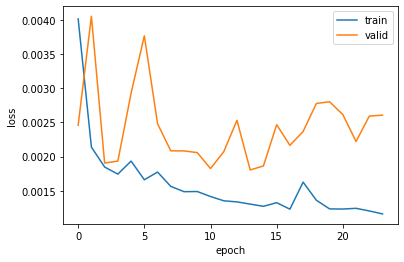

In [ ]:
plt.plot(history['loss'], label ="train")
plt.plot(history['val_loss'], label="valid")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)#Load TEST_DATASET
TEST_DF_RAW

,timestamp,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,...,P4_HT_PS,P4_LD,P4_ST_FD,P4_ST_GOV,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01,Attack
0,2021-07-10 0:00,0.059445,1.04366,431.328095,1034.712769,27.736847,14.91310,386.51172,31.52100,15.09755,...,0.716042,356.64423,0.00058,18131.0,292.86029,334.58112,20.989594,10000.0,27181.0,0.0
1,2021-07-10 0:00,0.059445,1.04217,431.328095,1034.712769,27.736847,14.95540,411.33905,31.51756,14.71477,...,0.716042,352.08698,-0.00282,18111.0,295.82605,332.97162,20.989594,9999.0,27174.0,0.0
2,2021-07-10 0:00,0.059445,1.03920,431.328095,1034.712769,27.736847,14.99200,438.15259,31.50269,14.30731,...,0.716042,347.63818,-0.00398,18100.0,300.02173,332.15784,20.989594,9999.0,27172.0,0.0
3,2021-07-10 0:00,0.059445,1.03222,431.328095,1034.712769,27.736847,15.01359,465.95908,31.47942,14.54943,...,0.716042,340.33203,-0.00152,18000.0,302.10144,330.96429,20.989594,9999.0,27168.0,0.0
4,2021-07-10 0:00,0.059445,1.02947,431.328095,1034.712769,27.736847,15.04767,452.05582,31.47942,15.24461,...,0.716042,335.17798,0.00072,17852.0,305.03113,329.02917,20.989594,9999.0,27172.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,2021-07-16 23:59,0.069440,1.04908,467.038540,1015.069640,25.687170,29.89865,1056.03259,29.45263,14.31306,...,2.403980,373.20966,0.00036,17966.0,318.08813,327.31122,26.760940,9917.0,26971.0,0.0
129596,2021-07-16 23:59,0.069440,1.05057,467.038540,1015.069640,25.687170,29.95392,1026.05530,29.45758,15.02294,...,2.403980,376.66376,-0.00470,18073.0,317.78070,327.36548,26.760940,9917.0,26970.0,0.0
129597,2021-07-16 23:59,0.069440,1.04839,467.038540,1015.069640,25.687170,29.99687,981.37659,29.45034,16.00788,...,2.403980,377.76691,-0.00130,17983.0,319.11890,326.62396,26.760940,9916.0,26973.0,0.0
129598,2021-07-16 23:59,0.069440,1.04255,467.038540,1015.069640,25.687170,30.02627,919.62439,29.43088,16.76628,...,2.403980,378.99664,0.00087,17956.0,316.78607,326.47931,26.760940,9916.0,26975.0,0.0


In [ ]:
TEST_DF_RAW.reset_index(drop=True,inplace=True)
TEST_DF_SET_COLUMNS=TEST_DF_RAW.set_axis(['timestamp', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86','attack'], axis =1)
TEST_DF_SET_COLUMNS=TEST_DF_SET_COLUMNS.dropna()
TEST_DF_NOT_NORMALIZE= TEST_DF_SET_COLUMNS[COL]
TEST_DF_NOT_NORMALIZE

,C45,C48,C53,C56,C57,C58,C55,C60,C61,C62,C63,C64,C65,C66,C67,C68
0,28.03510,129.60573,12.903438,54830.0,720.02826,927.0,2880.0,4.9870,-2.0395,6.8489,0.4010,12.00081,50.0,50.0,50.0,50.0
1,28.03419,129.60573,12.903438,54829.0,719.85382,926.0,2880.0,5.3008,-2.1750,7.0499,0.4187,11.96780,50.0,50.0,50.0,50.0
2,28.03429,129.60573,12.903438,54828.0,719.92407,927.0,2880.0,4.5175,-2.5854,6.8409,0.0691,11.92001,50.0,50.0,50.0,50.0
3,28.03686,129.60573,12.903438,54829.0,720.02954,924.0,2880.0,5.4640,-2.4722,7.2548,0.3306,11.93456,50.0,50.0,50.0,50.0
4,28.02990,129.60573,12.903438,54830.0,720.02905,927.0,2880.0,4.5850,-2.2319,6.7417,0.2150,11.96912,50.0,50.0,50.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336655,28.03953,108.24304,12.588700,54718.0,719.98303,904.0,2880.0,7.1499,-1.8328,9.3905,0.8050,12.02749,50.0,50.0,50.0,50.0
336656,28.03953,108.24304,12.588700,54718.0,719.98303,904.0,2880.0,7.1499,-1.8328,9.3905,0.8050,12.02749,50.0,50.0,50.0,50.0
336657,28.03169,108.24304,12.588700,54718.0,720.12372,906.0,2880.0,7.4013,-1.5833,9.4391,0.9984,12.05302,50.0,50.0,50.0,50.0
336658,28.03696,108.24304,12.588700,54717.0,720.08789,904.0,2880.0,7.4133,-1.4022,9.3506,1.0595,12.07077,50.0,50.0,50.0,50.0


In [ ]:
VALID_COLUMNS_IN_TEST_DATASET = TEST_DF_NOT_NORMALIZE.columns

In [ ]:
TEST_DF = normalize(TEST_DF_NOT_NORMALIZE[VALID_COLUMNS_IN_TEST_DATASET]) #MIN_MAX Normalize TEST_DF

In [ ]:
attack_answer = TEST_DF_SET_COLUMNS['attack']
attack_answer = attack_answer.to_numpy()
len(attack_answer)

336600

In [ ]:
boundary_check(TEST_DF)

(True, True, False)

In [ ]:
model = tf.keras.models.load_model('./drive/MyDrive/ICS_anomaly_detection/hai-22.04/models/ICS_5.h5')
x_test = TEST_DF.to_numpy()
test = x_test.reshape(-1,timesteps,x_test.shape[1])
predict_df = model.predict(test)

In [ ]:
predict_df = predict_df.reshape(-1,predict_df.shape[2])

In [ ]:
error = x_test - predict_df
mse = np.mean(np.power(error,2),axis=1)
print(mse.shape)

(336600,)


In [ ]:
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': attack_answer})

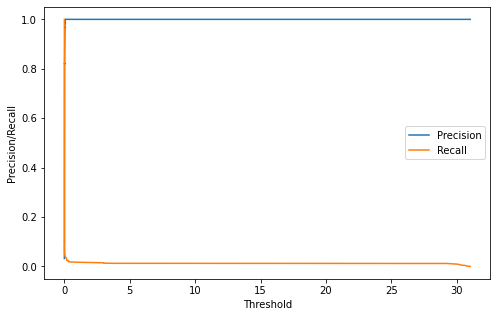

In [ ]:
precision_rt, recall_rt, threshold_rt = sklearn.metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])
plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()

pred_attack = np.zeros(len(mse))
for i in range(len(mse)):
  if mse[i] > 0.015: # 0.014
    pred_attack[i]=1
pred_attack

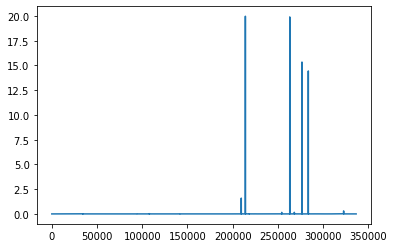

In [ ]:
mean_window = error_df['Reconstruction_error'].rolling(60,center=True).mean()
window_error = mean_window.fillna(0)
plt.plot(window_error)

In [ ]:
pred_attack = np.zeros(len(mse))
threshold = 0.008
for i in range(len(mse)):
  if window_error[i] > threshold:
    pred_attack[i]=1
pred_attack

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
len(pred_attack)

336600

In [ ]:
len(pred_attack[pred_attack==1])

1432

In [ ]:
attack_answer = np.where(attack_answer == 1,1,0)
np.unique(attack_answer,return_counts=True)

(array([0, 1]), array([325748,  10852]))

In [ ]:
print(confusion_matrix(attack_answer,pred_attack))
print(f1_score(attack_answer, pred_attack))
TaPR = etapr.evaluate_haicon(anomalies=attack_answer, predictions=pred_attack)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")

[[325362    386]
 [  9806   1046]]
0.17030283295343535
F1: 0.284 (TaP: 0.657, TaR: 0.181)
# of detected anomalies: 12


In [ ]:
pd.DataFrame(pred_attack).to_csv("./drive/MyDrive/ICS_anomaly_detection/hai-22.04/results/result_5.csv")